# Predicting fantasy points for kickers
In this notebook we'll bring in the target varible we've derived and create a model to predict fantasy points for kickers.<br>

Below are the model results.

In [123]:
error_dict = {'KNN': [45, 4.093921840711748],\
              'Ridge': [{'alpha': 100.0}, 4.158989477787983],\
              'Random Forest': [{'max_depth': 4, 'n_estimators': 100}, 4.064566369207579],\
              'Gradient Boost': [{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}, 4.065429448613024],\
              'XG Boost': [{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}, 4.065833788432901]}

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nfl_data_py as nfl
import sqlite3

# Connecting to the database
Here we'll connect to the team_defense and kicker_target tables in our sqlite database. Team_defense is the table we used to derive our defense target variable. It will probably work here, too. When we get to QB, RB, WR, and TE models, we'll probably need different features from that data and will have to create a new table.

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect('nfl_dfs.db')

# Query specific columns from the table
query1 = "SELECT * FROM team_defense"
kicker_df = pd.read_sql_query(query1, conn)

query2 = "SELECT * FROM kicker_target"
kicker_target = pd.read_sql_query(query2, conn)

# Close the connection
conn.close()

In [3]:
kicker_df.head()

,id,Unnamed: 0,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,...,div_game,roof,surface,pass,rush,posteam_score,posteam_score_post,defteam_score,defteam_score_post,desc
0,0,0,34.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,0.0,0.0,NaN,0.0,NaN,0.0,B.Daluiso kicks 72 yards from NYG 30 to ARI -2...
1,1,1,70.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,0.0,0.0,0.0,0.0,0.0,0.0,B.Daluiso kicks 69 yards from NYG 25 to ARI 6....
2,2,2,106.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,0.0,1.0,0.0,0.0,0.0,0.0,(15:00) T.Jones left end to ARI 37 for 2 yards...
3,3,3,131.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,1.0,0.0,0.0,0.0,0.0,0.0,(14:04) J.Plummer pass incomplete to T.Jones.
4,4,4,148.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,1.0,0.0,0.0,0.0,0.0,0.0,(13:57) (Shotgun) J.Plummer pass incomplete to...


In [4]:
kicker_target.head()

,season,week,game_id,kicker_player_name,home_team,away_team,posteam,defteam,FD_Pts,FG_39,FG_49,FG_50_plus
0,2001,1,2001_01_ATL_SF,J.Cortez,SF,ATL,SF,ATL,10.0,3,0,0
1,2001,1,2001_01_ATL_SF,J.Feely,SF,ATL,ATL,SF,7.0,2,0,0
2,2001,1,2001_01_CAR_MIN,G.Anderson,MIN,CAR,MIN,CAR,1.0,0,0,0
3,2001,1,2001_01_CAR_MIN,J.Kasay,MIN,CAR,CAR,MIN,6.0,1,0,0
4,2001,1,2001_01_CHI_BAL,M.Stover,BAL,CHI,BAL,CHI,5.0,1,0,0


In [5]:
len(kicker_target)

12162

In [6]:
kicker_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12162 entries, 0 to 12161
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   season              12162 non-null  int64  
 1   week                12162 non-null  int64  
 2   game_id             12162 non-null  object 
 3   kicker_player_name  12162 non-null  object 
 4   home_team           12162 non-null  object 
 5   away_team           12162 non-null  object 
 6   posteam             12162 non-null  object 
 7   defteam             12162 non-null  object 
 8   FD_Pts              12162 non-null  float64
 9   FG_39               12162 non-null  int64  
 10  FG_49               12162 non-null  int64  
 11  FG_50_plus          12162 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 1.1+ MB


In [7]:
kicker_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135207 entries, 0 to 1135206
Data columns (total 67 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   id                             1135207 non-null  int64  
 1   Unnamed: 0                     1135207 non-null  int64  
 2   play_id                        1135207 non-null  float64
 3   game_id                        1135207 non-null  object 
 4   old_game_id                    1135207 non-null  int64  
 5   home_team                      1135207 non-null  object 
 6   away_team                      1135207 non-null  object 
 7   season_type                    1135207 non-null  object 
 8   week                           1135207 non-null  int64  
 9   posteam                        1071824 non-null  object 
 10  posteam_type                   1071888 non-null  object 
 11  defteam                        1071888 non-null  object 
 12  sp            

In [8]:
group_list = ['season', 'week', 'game_id', 'home_team', 'away_team']

In [9]:
spread_df = kicker_df.groupby(group_list).agg({'spread_line': 'mean', 'total_line' : 'mean', 'roof': 'first', 'surface': 'first'}).reset_index()

In [10]:
spread_df = pd.DataFrame(spread_df)

In [11]:
spread_df.head()

,season,week,game_id,home_team,away_team,spread_line,total_line,roof,surface
0,2000,1,2000_01_ARI_NYG,NYG,ARI,6.5,40.0,outdoors,grass
1,2000,1,2000_01_BAL_PIT,PIT,BAL,-2.5,37.0,outdoors,astroturf
2,2000,1,2000_01_CAR_WAS,WAS,CAR,10.5,47.5,outdoors,grass
3,2000,1,2000_01_CHI_MIN,MIN,CHI,4.5,46.5,dome,astroturf
4,2000,1,2000_01_DEN_STL,LA,DEN,6.5,48.5,dome,astroturf


In [12]:
spread_df['roof'] = np.where((spread_df['roof'] == 'outdoors') | (spread_df['roof'] == 'open'), 1, 0)
spread_df['surface'] = np.where((spread_df['surface'] == 'grass') | (spread_df['surface'] == 'grass '), 1, 0)
spread_df['home'] = 0

In [13]:
spread_df_H = spread_df.copy()
spread_df_A = spread_df.copy()

In [14]:
# Assign new column 'def_team' and keep only necessary columns for each new row
spread_df_H['defteam'] = spread_df_H['home_team']
spread_df_H['opponent'] = spread_df_H['away_team']
spread_df_H = spread_df_H[['season', 'week', 'game_id', 'defteam', 'opponent', 'spread_line', 'total_line', 'roof', 'surface', 'home_team']]
spread_df_H.columns = ['season', 'week', 'game_id', 'defteam', 'opponent', 'spread_line', 'total_line', 'roof', 'surface', 'home_team']
spread_df_H['home_team'] = 1

spread_df_A['defteam'] = spread_df_A['away_team']
spread_df_A['opponent'] = spread_df_A['home_team']
spread_df_A = spread_df_A[['season', 'week', 'game_id', 'defteam', 'opponent', 'spread_line', 'total_line', 'roof', 'surface', 'home_team']]
spread_df_A.columns = ['season', 'week', 'game_id', 'defteam', 'opponent', 'spread_line', 'total_line', 'roof', 'surface', 'home_team']
spread_df_A['home_team'] = 0

In [15]:
#Point spread needs to be negated for away team since it's from perspective of home team
spread_df_A['spread_line'] = np.where(spread_df_A['spread_line'] == 0, 0, -spread_df_A['spread_line'])

In [16]:
spread_df = pd.concat([spread_df_A, spread_df_H])

In [17]:
spread_df = spread_df.sort_values(['season', 'week', 'game_id', 'defteam']).reset_index(drop = True)

In [18]:
spread_df.rename(columns = {'roof': 'outdoors', 'surface' : 'grass'}, inplace = True)

# Predicted total
We derive the predicted point total for the kicker's team. For defense, this variable was the predicted point total of the opponent. For kickers and the rest of our models, this variable is the predicted points in the game for the player's team.

In [19]:
spread_df['pred_total'] = np.round((spread_df['total_line']/2) + (spread_df['spread_line']/2), 2)

In [20]:
spread_df['opp_total'] = np.round((spread_df['total_line']/2) - (spread_df['spread_line']/2), 2)

In [21]:
spread_df.rename(columns = {'defteam' : 'team'}, inplace = True)

In [22]:
spread_df.head(10)

,season,week,game_id,team,opponent,spread_line,total_line,outdoors,grass,home_team,pred_total,opp_total
0,2000,1,2000_01_ARI_NYG,ARI,NYG,-6.5,40.0,1,1,0,16.75,23.25
1,2000,1,2000_01_ARI_NYG,NYG,ARI,6.5,40.0,1,1,1,23.25,16.75
2,2000,1,2000_01_BAL_PIT,BAL,PIT,2.5,37.0,1,0,0,19.75,17.25
3,2000,1,2000_01_BAL_PIT,PIT,BAL,-2.5,37.0,1,0,1,17.25,19.75
4,2000,1,2000_01_CAR_WAS,CAR,WAS,-10.5,47.5,1,1,0,18.50,29.00
5,2000,1,2000_01_CAR_WAS,WAS,CAR,10.5,47.5,1,1,1,29.00,18.50
6,2000,1,2000_01_CHI_MIN,CHI,MIN,-4.5,46.5,0,0,0,21.00,25.50
7,2000,1,2000_01_CHI_MIN,MIN,CHI,4.5,46.5,0,0,1,25.50,21.00
8,2000,1,2000_01_DEN_STL,DEN,LA,-6.5,48.5,0,0,0,21.00,27.50
9,2000,1,2000_01_DEN_STL,LA,DEN,6.5,48.5,0,0,1,27.50,21.00


# Creating a point spreads table
We've created spread_df manually for the defense and kicker models. Since this data will be used for the four other models we still need to create, we'll put this in our database so we can just fetch it in the future.

In [23]:
# conn = sqlite3.connect('nfl_dfs.db')

# # Define the table name
# table_name = 'spreads_totals'

# # Specify data types
# dtype = {
#     'season': 'INTEGER',
#     'week': 'INTEGER',
#     'game_id': 'TEXT',
#     'team': 'TEXT',
#     'opponent': 'TEXT',
#     'spread_line': 'REAL',
#     'total_line': 'REAL',
#     'outdoors': 'INTEGER',
#     'grass': 'INTEGER',
#     'home_team': 'INTEGER',
#     'pred_total': 'REAL',
#     'opp_total': 'REAL'
# }

# # Write the dataframe to the SQLite table
# spread_df.to_sql(table_name, conn, if_exists='replace', index=False, dtype=dtype)

# # Confirm that the data has been written
# print(f"Data written to table {table_name} in SQLite database nfl_fantasy.db")

# # Close the connection
# conn.close()

Data written to table spreads_totals in SQLite database nfl_fantasy.db


In [24]:
# Connect to the SQLite database
conn = sqlite3.connect('nfl_dfs.db')

# Query specific columns from the table
query1 = "SELECT * FROM spreads_totals"
spread_df = pd.read_sql_query(query1, conn)

# Close the connection
conn.close()

In [25]:
kicker_target.head()

,season,week,game_id,kicker_player_name,home_team,away_team,posteam,defteam,FD_Pts,FG_39,FG_49,FG_50_plus
0,2001,1,2001_01_ATL_SF,J.Cortez,SF,ATL,SF,ATL,10.0,3,0,0
1,2001,1,2001_01_ATL_SF,J.Feely,SF,ATL,ATL,SF,7.0,2,0,0
2,2001,1,2001_01_CAR_MIN,G.Anderson,MIN,CAR,MIN,CAR,1.0,0,0,0
3,2001,1,2001_01_CAR_MIN,J.Kasay,MIN,CAR,CAR,MIN,6.0,1,0,0
4,2001,1,2001_01_CHI_BAL,M.Stover,BAL,CHI,BAL,CHI,5.0,1,0,0


# Dropping columns from kicker_target
We only really need a column to indicate each kicker's team, along with the target variable and the variables we'll use. Home team and away team will be indicated in the point spread data.

In [26]:
kicker_target.drop(columns = ['home_team', 'away_team', 'defteam'], inplace = True)

In [27]:
kicker_target.rename(columns = {'posteam': 'team'}, inplace = True)

In [28]:
kicker_target.head()

,season,week,game_id,kicker_player_name,team,FD_Pts,FG_39,FG_49,FG_50_plus
0,2001,1,2001_01_ATL_SF,J.Cortez,SF,10.0,3,0,0
1,2001,1,2001_01_ATL_SF,J.Feely,ATL,7.0,2,0,0
2,2001,1,2001_01_CAR_MIN,G.Anderson,MIN,1.0,0,0,0
3,2001,1,2001_01_CAR_MIN,J.Kasay,CAR,6.0,1,0,0
4,2001,1,2001_01_CHI_BAL,M.Stover,BAL,5.0,1,0,0


In [29]:
kick_model = pd.merge(kicker_target, spread_df, on = ['season', 'week', 'game_id', 'team'], how = 'left')

In [30]:
kick_model.drop(columns = 'opp_total', inplace = True)

# Creating defense_vs_position columns
Just like we did with defense, we're creating columns to indicate how many points kickers have scored against each opponent in the previous eight games, and we're weighing them so that more recent games carry more weight. Instead of opp_vs_def, the name convention now will be def_vs_pos. It will be that way for the rest of the project as we'll be looking at how many points kickers, QBs, RBs, WRs and TEs tend to score against certain teams.

In [31]:
def_vs_pos = kick_model[['season', 'week', 'game_id', 'kicker_player_name', 'opponent', 'FD_Pts']]

In [32]:
def_vs_pos = def_vs_pos.sort_values(by=['opponent', 'season', 'week', 'game_id'])

In [33]:
def_vs_pos['game_num'] = def_vs_pos.groupby(['opponent', 'season']).cumcount() + 1

In [34]:
# Function to calculate equally weighted rolling mean
def calculate_equal_rolling_mean(group):
    # Calculate the equally weighted rolling mean of the last 8 games, excluding the current game
    group['rolling_mean_8'] = (
        group['FD_Pts'].shift().rolling(window=8, min_periods=1).mean()
    )
    return group

# Apply the rolling mean calculation using groupby
def_vs_pos = def_vs_pos.groupby('opponent', group_keys=False).apply(calculate_equal_rolling_mean)


In [35]:
# Linear and Exponential weights
# linear_weights = np.array([0.25, 0.20, 0.15, 0.13, 0.10, 0.08, 0.05, 0.04])
# exponential_weights = np.array([0.27, 0.23, 0.19, 0.15, 0.11, 0.09, 0.07, 0.05])

# Corrected Linear and Exponential weights
linear_weights = np.array([0.01, 0.03, 0.06, 0.10, 0.14, 0.18, 0.24, 0.28])
exponential_weights = np.array([0.015, 0.025, 0.04, 0.07, 0.10, 0.15, 0.25, 0.35])


In [36]:
# Function to calculate rolling means with different weights
def calculate_weighted_means(group):
    # Calculate the linear weighted rolling mean
    group['linear_rolling_mean_8'] = (
        group['FD_Pts'].shift().rolling(window=8, min_periods=1)
        .apply(lambda x: np.dot(x, linear_weights[-len(x):]), raw=False)
    )
    
    # Calculate the exponential weighted rolling mean
    group['exponential_rolling_mean_8'] = (
        group['FD_Pts'].shift().rolling(window=8, min_periods=1)
        .apply(lambda x: np.dot(x, exponential_weights[-len(x):]), raw=False)
    )
    return group

In [37]:
# Apply the calculations using groupby
def_vs_pos = def_vs_pos.groupby('opponent', group_keys=False).apply(calculate_weighted_means)

In [38]:
def_vs_pos.rename(columns = {'rolling_mean_8': 'def_vs_pos_L8',\
                             'linear_rolling_mean_8': 'def_vs_pos_L8_lin',\
                            'exponential_rolling_mean_8': 'def_vs_pos_L8_exp'}, inplace = True)

In [39]:
def_vs_pos.drop(columns = ['FD_Pts', 'game_num'], inplace = True)

In [40]:
def_vs_pos

,season,week,game_id,kicker_player_name,opponent,def_vs_pos_L8,def_vs_pos_L8_lin,def_vs_pos_L8_exp
38,2001,2,2001_02_DEN_ARI,J.Elam,ARI,NaN,NaN,NaN
59,2001,3,2001_03_ATL_ARI,J.Feely,ARI,13.000000,NaN,NaN
87,2001,4,2001_04_ARI_PHI,D.Akers,ARI,12.500000,NaN,NaN
116,2001,5,2001_05_ARI_CHI,P. Edinger,ARI,11.333333,NaN,NaN
158,2001,6,2001_06_KC_ARI,T. Peterson,ARI,11.000000,NaN,NaN
...,...,...,...,...,...,...,...,...
11992,2023,13,2023_13_MIA_WAS,J.Sanders,WAS,3.000000,3.41,3.415
12053,2023,15,2023_15_WAS_LA,L.Havrisik,WAS,3.250000,4.21,4.305
12081,2023,16,2023_16_WAS_NYJ,G.Zuerlein,WAS,3.375000,3.77,3.575
12109,2023,17,2023_17_SF_WAS,J.Moody,WAS,3.500000,3.59,3.335


In [41]:
kick_model.drop(columns = ['FG_39', 'FG_49', 'FG_50_plus'], inplace = True)

In [42]:
def_vs_pos.drop(columns = ['opponent'], inplace = True)

In [43]:
kick_model = pd.merge(kick_model, def_vs_pos, on = ['season', 'week', 'game_id', 'kicker_player_name'], how = 'left')

In [44]:
kick_model.head()

,season,week,game_id,kicker_player_name,team,FD_Pts,opponent,spread_line,total_line,outdoors,grass,home_team,pred_total,def_vs_pos_L8,def_vs_pos_L8_lin,def_vs_pos_L8_exp
0,2001,1,2001_01_ATL_SF,J.Cortez,SF,10.0,ATL,3.5,46.0,1,1,1,24.75,NaN,NaN,NaN
1,2001,1,2001_01_ATL_SF,J.Feely,ATL,7.0,SF,-3.5,46.0,1,1,0,21.25,NaN,NaN,NaN
2,2001,1,2001_01_CAR_MIN,G.Anderson,MIN,1.0,CAR,10.0,45.0,0,0,1,27.50,NaN,NaN,NaN
3,2001,1,2001_01_CAR_MIN,J.Kasay,CAR,6.0,MIN,-10.0,45.0,0,0,0,17.50,NaN,NaN,NaN
4,2001,1,2001_01_CHI_BAL,M.Stover,BAL,5.0,CHI,10.5,33.5,1,1,1,22.00,NaN,NaN,NaN


In [45]:
kick_model.dropna(inplace = True)

In [46]:
kick_model.drop(columns = ['opponent'], inplace = True)

In [47]:
kick_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11906 entries, 205 to 12161
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   season              11906 non-null  int64  
 1   week                11906 non-null  int64  
 2   game_id             11906 non-null  object 
 3   kicker_player_name  11906 non-null  object 
 4   team                11906 non-null  object 
 5   FD_Pts              11906 non-null  float64
 6   spread_line         11906 non-null  float64
 7   total_line          11906 non-null  float64
 8   outdoors            11906 non-null  int64  
 9   grass               11906 non-null  int64  
 10  home_team           11906 non-null  int64  
 11  pred_total          11906 non-null  float64
 12  def_vs_pos_L8       11906 non-null  float64
 13  def_vs_pos_L8_lin   11906 non-null  float64
 14  def_vs_pos_L8_exp   11906 non-null  float64
dtypes: float64(7), int64(5), object(3)
memory usage: 1.5+ MB

# Splitting data into odd and even years
We're going to run the model on even years only. That way if we want to refine the model down the road, we'll have untouched data we can use. 

In [48]:
kick_model_even = kick_model[kick_model['season']%2 == 0]

In [49]:
kick_model_even['season'].value_counts()

season
2020    539
2004    533
2010    532
2008    531
2016    531
2012    529
2014    527
2006    526
2018    524
2022    524
2002    522
Name: count, dtype: int64

In [50]:
kick_model_even.set_index(['season', 'week', 'game_id', 'kicker_player_name', 'team'], inplace = True)

In [51]:
kick_model_even

FD_Pts  spread_line  \
season week game_id         kicker_player_name team                        
2002   1    2002_01_ARI_WAS B.Conway           WAS      7.0          6.0   
                            B.Gramatica        ARI     11.0         -6.0   
            2002_01_ATL_GB  J.Feely            ATL     12.0         -7.0   
                            R.Longwell         GB      14.0          7.0   
            2002_01_BAL_CAR J.Kasay            CAR      4.0          0.0   
...                                                     ...          ...   
2022   21   2022_21_CIN_KC  H.Butker           KC       2.0          2.0   
            2022_21_SF_PHI  J.Elliott          PHI      4.0          2.5   
                            R.Gould            SF       1.0         -2.5   
       22   2022_22_KC_PHI  H.Butker           KC       5.0         -1.0   
                            J.Elliott          PHI      3.0          1.0   

                                                     total_line  outdoors  \
season week game_id         kicker_player_name team                         
2002   1    2002_01_ARI_WAS B.Conway           WAS         44.5         1   
                            B.Gramatica        ARI         44.5         1   
            2002_01_ATL_GB  J.Feely            ATL         42.5         1   
                            R.Longwell         GB          42.5         1   
            2002_01_BAL_CAR J.Kasay            CAR         33.0         1   
...                                                         ...       ...   
2022   21   2022_21_CIN_KC  H.Butker           KC          48.5         1   
            2022_21_SF_PHI  J.Elliott          PHI         45.0         1   
                            R.Gould            SF          45.0         1   
       22   2022_22_KC_PHI  H.Butker           KC          51.0         0   
                            J.Elliott          PHI         51.0         0   

                                                     grass  home_team  \
season week game_id         kicker_player_name team                     
2002   1    2002_01_ARI_WAS B.Conway           WAS       1          1   
                            B.Gramatica        ARI       1          0   
            2002_01_ATL_GB  J.Feely            ATL       1          0   
                            R.Longwell         GB        1          1   
            2002_01_BAL_CAR J.Kasay            CAR       1          1   
...                                                    ...        ...   
2022   21   2022_21_CIN_KC  H.Butker           KC        1          1   
            2022_21_SF_PHI  J.Elliott          PHI       1          1   
                            R.Gould            SF        1          0   
       22   2022_22_KC_PHI  H.Butker           KC        1          0   
                            J.Elliott          PHI       1          1   

                                                     pred_total  \
season week game_id         kicker_player_name team               
2002   1    2002_01_ARI_WAS B.Conway           WAS        25.25   
                            B.Gramatica        ARI        19.25   
            2002_01_ATL_GB  J.Feely            ATL        17.75   
                            R.Longwell         GB         24.75   
            2002_01_BAL_CAR J.Kasay            CAR        16.50   
...                                                         ...   
2022   21   2022_21_CIN_KC  H.Butker           KC         25.25   
            2022_21_SF_PHI  J.Elliott          PHI        23.75   
                            R.Gould            SF         21.25   
       22   2022_22_KC_PHI  H.Butker           KC         25.00   
                            J.Elliott          PHI        26.00   

                                                     def_vs_pos_L8  \
season week game_id         kicker_player_name team                  
2002   1    2002_01_ARI_WAS B.Conway           WAS           5.750   
                            B.

# Exploratory Data Analysis

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 

In [53]:
kick_model_even.describe()

,FD_Pts,spread_line,total_line,outdoors,grass,home_team,pred_total,def_vs_pos_L8,def_vs_pos_L8_lin,def_vs_pos_L8_exp
count,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000
mean,7.277838,0.031024,44.112152,0.750773,0.568408,0.501031,22.071588,7.437254,7.686541,7.380758
std,4.314002,6.158997,4.990623,0.432602,0.495341,0.500042,3.967345,2.030930,2.421588,2.463192
min,0.000000,-20.000000,30.000000,0.000000,0.000000,0.000000,8.500000,1.000000,0.670000,0.565000
25%,4.000000,-4.000000,41.000000,1.000000,0.000000,0.000000,19.250000,6.375000,6.250000,5.850000
50%,7.000000,1.000000,44.000000,1.000000,1.000000,1.000000,22.000000,7.500000,7.780000,7.412500
75%,10.000000,4.000000,47.500000,1.000000,1.000000,1.000000,25.000000,8.750000,9.310000,9.035000
max,29.500000,20.000000,63.500000,1.000000,1.000000,1.000000,36.250000,13.250000,16.050000,16.675000


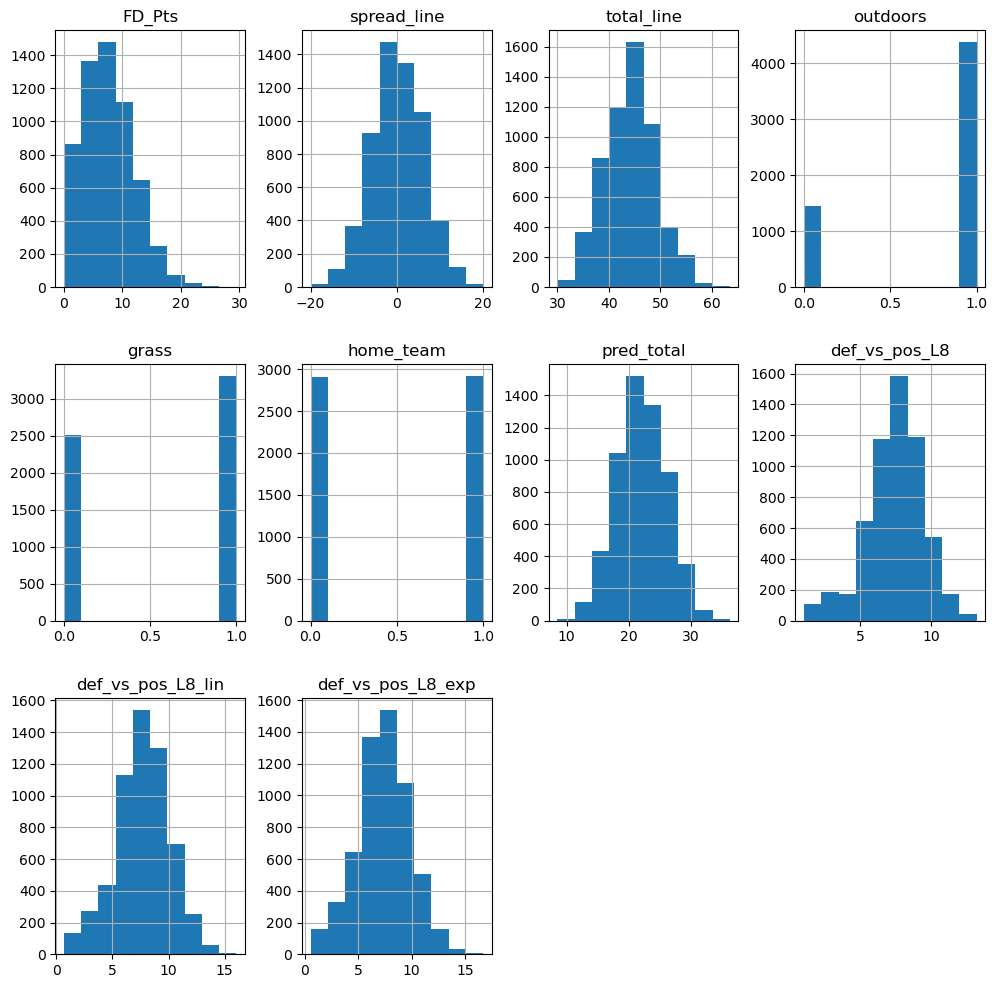

In [54]:
kick_model_even.hist(layout = (3, 4), figsize = (12, 12))
#plt.subplots_adjust(hspace=1)
plt.show();

In [55]:
corr_df = kick_model_even.corr()

In [56]:
corr_df['FD_Pts'].sort_values(ascending = False)

FD_Pts               1.000000
def_vs_pos_L8        0.256449
def_vs_pos_L8_lin    0.255996
def_vs_pos_L8_exp    0.245935
pred_total           0.158835
spread_line          0.133579
total_line           0.087684
home_team            0.034770
outdoors            -0.034032
grass               -0.034719
Name: FD_Pts, dtype: float64

In [57]:
main_df = kick_model_even

In [58]:
X = main_df[['spread_line', 'home_team', 'outdoors', 'grass', 'total_line', 'pred_total', 'def_vs_pos_L8', 'def_vs_pos_L8_lin', 'def_vs_pos_L8_exp']]

In [59]:
y = main_df[['FD_Pts']]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

In [61]:
from sklearn.preprocessing import StandardScaler

In [62]:
scaler = StandardScaler()

In [63]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
X_scaled_df = pd.DataFrame(X_train_scaled, columns = X.columns)

In [65]:
X_scaled_df.mean()

spread_line         -1.832195e-17
home_team            3.489896e-17
outdoors            -2.966411e-17
grass               -2.268432e-17
total_line          -1.134216e-17
pred_total           4.022105e-16
def_vs_pos_L8        1.526829e-16
def_vs_pos_L8_lin    1.064418e-16
def_vs_pos_L8_exp   -6.805296e-17
dtype: float64

In [66]:
X_scaled_df.std()

spread_line          1.000123
home_team            1.000123
outdoors             1.000123
grass                1.000123
total_line           1.000123
pred_total           1.000123
def_vs_pos_L8        1.000123
def_vs_pos_L8_lin    1.000123
def_vs_pos_L8_exp    1.000123
dtype: float64

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [68]:
from sklearn.metrics import mean_absolute_error

In [69]:
from collections import defaultdict

In [71]:
error_dict = defaultdict(float)

# K Nearest Neighbors

In [72]:
# Lists to store the RMSE values and corresponding number of neighbors
rmse_list = []
neighbors_list = []

# Loop over a range of 1 to 80 neighbors
for i in range(1, 81):
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    
    # Calculate and print the errors
    print(f"Mean Absolute Error with {i} neighbors: {mean_absolute_error(y_test, y_pred)}")
    print(f"Mean Squared Error with {i} neighbors: {mean_squared_error(y_test, y_pred)}")
    print(f"Root Mean Squared Error with {i} neighbors: {mean_squared_error(y_test, y_pred, squared=False)}")
    print()
    
    # Append the results to the lists
    rmse_list.append(mean_squared_error(y_test, y_pred, squared=False))
    neighbors_list.append(i)

# Combine the lists into a dictionary and sort by RMSE
knn_dict = dict(zip(neighbors_list, rmse_list))
sorted_knn = dict(sorted(knn_dict.items(), key=lambda item: item[1]))

sorted_knn

Mean Absolute Error with 1 neighbors: 4.379851088205188
Mean Squared Error with 1 neighbors: 31.735054066478337
Root Mean Squared Error with 1 neighbors: 5.633387441538026

Mean Absolute Error with 2 neighbors: 3.863487972512005
Mean Squared Error with 2 neighbors: 24.613333505231807
Root Mean Squared Error with 2 neighbors: 4.961182672028093

Mean Absolute Error with 3 neighbors: 3.676193203518196
Mean Squared Error with 3 neighbors: 21.799929464241544
Root Mean Squared Error with 3 neighbors: 4.669039458415568

Mean Absolute Error with 4 neighbors: 3.575429553270579
Mean Squared Error with 4 neighbors: 20.33743989125532
Root Mean Squared Error with 4 neighbors: 4.5097050780794214

Mean Absolute Error with 5 neighbors: 3.512345933565125
Mean Squared Error with 5 neighbors: 19.675429984018205
Root Mean Squared Error with 5 neighbors: 4.435699492077682

Mean Absolute Error with 6 neighbors: 3.462773959524716
Mean Squared Error with 6 neighbors: 19.333927586871326
Root Mean Squared Error

{45: 4.093921840711748,
 46: 4.095331619456619,
 48: 4.096173398084173,
 47: 4.096656561178963,
 52: 4.097345392322058,
 44: 4.097387468398816,
 50: 4.0975063496337345,
 49: 4.097717048661715,
 73: 4.098393116750839,
 51: 4.098500077566805,
 80: 4.09864988018526,
 79: 4.09892692113559,
 53: 4.098990482530309,
 72: 4.099231489808993,
 43: 4.099321801940492,
 74: 4.099692909021962,
 78: 4.100036959345109,
 77: 4.100189243699396,
 59: 4.100282366511751,
 62: 4.100420373153452,
 54: 4.100444580318195,
 71: 4.100578687250675,
 57: 4.100813835114119,
 76: 4.101152541340699,
 58: 4.10119355878547,
 55: 4.101327648561375,
 70: 4.101550679773425,
 56: 4.10171500654127,
 69: 4.1018094672292005,
 42: 4.101820629451667,
 75: 4.101886383622813,
 60: 4.1021097642744815,
 61: 4.1022456568641825,
 67: 4.1032806679869,
 65: 4.103294142331159,
 63: 4.103431096092506,
 64: 4.103542067787457,
 68: 4.103793208329929,
 41: 4.104110126329821,
 66: 4.104439933008311,
 39: 4.104722114896882,
 40: 4.10478500294

In [73]:
for i, (k, v) in enumerate(sorted_knn.items()):
    neighbors = k
    best_rmse = v
    print(f"{k}: {v}")
    break

45: 4.093921840711748


In [74]:
error_dict['KNN'] = [neighbors, min(rmse_list)]

# Linear Regression

In [75]:
base_LR = LinearRegression()

In [76]:
base_LR.fit(X_train_scaled, y_train)

LinearRegression()

In [77]:
base_LR_pred = base_LR.predict(X_test_scaled)

In [78]:
print(f"R_squared_train: {base_LR.score(X_train_scaled, y_train)}")
print(f"R_squared_test: {base_LR.score(X_test_scaled, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, base_LR_pred)}")
print(f"MSE: {mean_squared_error(y_test, base_LR_pred)}")
print(f"RMSE: {mean_squared_error(y_test, base_LR_pred, squared = False)}")

R_squared_train: 0.08921588555350612
R_squared_test: 0.06510430241764442
MAE: 3.349950238484027
MSE: 17.280401861872505
RMSE: 4.156970274355171


In [79]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [80]:
alpha_values = np.linspace(0.1, 100, 50)

In [81]:
param_grid = {'alpha': alpha_values}
Ridge_LR = Ridge()
Ridge_CV = GridSearchCV(Ridge_LR, param_grid, cv = 5, scoring = 'neg_root_mean_squared_error')
Ridge_CV.fit(X_train_scaled, y_train)
best_params = Ridge_CV.best_params_
print(f"Ridge_model best params: {best_params}")
print(f"Ridge_model best score: {-Ridge_CV.best_score_}")

Ridge_model best params: {'alpha': 100.0}
Ridge_model best score: 4.131592606993969


In [82]:
best_ridge = Ridge(alpha=100, random_state=42)
best_ridge.fit(X_train_scaled, y_train)  # Use the correct variable name
y_pred = best_ridge.predict(X_test_scaled)  # Use the correct variable name

best_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"best_ridge train R-squared: {best_ridge.score(X_train_scaled, y_train)}")
print(f"best_ridge test R-squared: {best_ridge.score(X_test_scaled, y_test)}")
print(f"best_ridge MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"best_ridge RMSE: {best_rmse}")
print(f"best_ridge MSE: {mean_squared_error(y_test, y_pred)}")

best_ridge train R-squared: 0.08931152594843206
best_ridge test R-squared: 0.06419585085170088
best_ridge MAE: 3.349874978336791
best_ridge RMSE: 4.158989477787983
best_ridge MSE: 17.297193476351154


In [83]:
error_dict['Ridge'] = [best_params, best_rmse]

# Random Forest

In [85]:
from sklearn.ensemble import RandomForestRegressor

In [86]:
base_RF = RandomForestRegressor(random_state = 42)

In [87]:
base_RF.fit(X_train_scaled, y_train)

C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [88]:
base_RF_pred = base_RF.predict(X_test_scaled)

In [89]:
print(f"R_squared_train: {base_RF.score(X_train_scaled, y_train)}")
print(f"R_squared_test: {base_RF.score(X_test_scaled, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, base_RF_pred)}")
print(f"MSE: {mean_squared_error(y_test, base_RF_pred)}")
print(f"RMSE: {mean_squared_error(y_test, base_RF_pred, squared = False)}")

R_squared_train: 0.8701539230154418
R_squared_test: 0.022158193982793062
MAE: 3.353569988549899
MSE: 18.074208073706536
RMSE: 4.251377197298134


In [90]:
from sklearn.metrics import make_scorer

In [91]:
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

In [92]:
param_grid = {'max_depth': [2, 3, 4], 'n_estimators': [100, 200, 300]}
RF_CV = GridSearchCV(base_RF, param_grid, scoring=rmse_scorer, cv = 5, n_jobs = 2, verbose = 3)
RF_CV.fit(X_train_scaled, y_train)
best_params = RF_CV.best_params_
print(f"Tuned Random Forest Best Estimator: {RF_CV.best_estimator_}")
print(f"Tuned Random Forest Best Score: {RF_CV.best_score_}")
print(f"Tuned Random Forest Best Params: {best_params}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Tuned Random Forest Best Estimator: RandomForestRegressor(max_depth=4, random_state=42)
Tuned Random Forest Best Score: -4.055598614010492
Tuned Random Forest Best Params: {'max_depth': 4, 'n_estimators': 100}


In [93]:
best_RF = RandomForestRegressor(max_depth=4, n_estimators=100, random_state=42)
best_RF.fit(X_train_scaled, y_train)  # Correct the variable name for consistency
y_pred = best_RF.predict(X_test_scaled)  # Correct the variable name for consistency

best_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Best_RF Train R-squared: {best_RF.score(X_train_scaled, y_train)}")
print(f"Best_RF Test R-squared: {best_RF.score(X_test_scaled, y_test)}")
print(f"Best_RF MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Best_RF RMSE: {best_rmse}")
print(f"Best_RF MSE: {mean_squared_error(y_test, y_pred)}")

C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best_RF Train R-squared: 0.14753070124432321
Best_RF Test R-squared: 0.10620532675144467
Best_RF MAE: 3.222125227945887
Best_RF RMSE: 4.064566369207579
Best_RF MSE: 16.52069976969328


In [94]:
error_dict["Random Forest"] = [best_params, best_rmse]

In [95]:
error_dict

defaultdict(float,
            {'KNN': [45, 4.093921840711748],
             'Ridge': [{'alpha': 100.0}, 4.158989477787983],
             'Random Forest': [{'max_depth': 4, 'n_estimators': 100},
              4.064566369207579]})

# Gradient Boost

In [96]:
from sklearn.ensemble import GradientBoostingRegressor

In [97]:
base_GB = GradientBoostingRegressor(random_state = 42)

In [98]:
base_GB.fit(X_train_scaled, y_train)

C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(random_state=42)

In [99]:
y_pred = base_GB.predict(X_test_scaled)

In [100]:
print(f"Base GB R_squared_train: {base_GB.score(X_train_scaled, y_train)}")
print(f"Base GB R_squared_test: {base_GB.score(X_test_scaled, y_test)}")
print(f"Base GB MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Base GB MSE: {mean_squared_error(y_test, y_pred)}")
print(f"Base GB RMSE: {mean_squared_error(y_test, y_pred, squared = False)}")

Base GB R_squared_train: 0.2131871540200373
Base GB R_squared_test: 0.09533746067389903
Base GB MAE: 3.2312561026218463
Base GB MSE: 16.721578962619997
Base GB RMSE: 4.089202729459619


In [101]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4]
}

In [102]:
GB_CV = GridSearchCV(base_GB, param_grid, scoring=rmse_scorer, cv = 5, n_jobs = 2, verbose = 3)
GB_CV.fit(X_train_scaled, y_train)
best_params = GB_CV.best_params_
print(f"Tuned Gradient Boost Best Estimator: {GB_CV.best_estimator_}")
print(f"Tuned Gradient Boost Best Score: {GB_CV.best_score_}")
print(f"Tuned Gradient Boost Best Params: {best_params}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Tuned Gradient Boost Best Estimator: GradientBoostingRegressor(learning_rate=0.01, n_estimators=300, random_state=42)
Tuned Gradient Boost Best Score: -4.054667857193908
Tuned Gradient Boost Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


In [103]:
best_GB = GradientBoostingRegressor(max_depth=3, n_estimators=300, learning_rate = 0.01, random_state=42)
best_GB.fit(X_train_scaled, y_train)  # Correct the variable name for consistency
y_pred = best_GB.predict(X_test_scaled)  # Correct the variable name for consistency

best_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Best_GB Train R-squared: {best_GB.score(X_train_scaled, y_train)}")
print(f"Best_GB Test R-squared: {best_GB.score(X_test_scaled, y_test)}")
print(f"Best_GB MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Best_GB RMSE: {best_rmse}")
print(f"Best_GB MSE: {mean_squared_error(y_test, y_pred)}")

C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best_GB Train R-squared: 0.1564978854137845
Best_GB Test R-squared: 0.10582570560261806
Best_GB MAE: 3.2238002888431505
Best_GB RMSE: 4.065429448613024
Best_GB MSE: 16.527716601649995


In [104]:
error_dict["Gradient Boost"] = [best_params, best_rmse]

# XG Boost

In [106]:
import xgboost as xgb

In [107]:
base_XGB = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [108]:
# Fit the best model on the training data
base_XGB.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [109]:
# Make predictions on the test data
y_pred = base_XGB.predict(X_test_scaled)

In [110]:
print(f"Base XGB R_squared_train: {base_XGB.score(X_train_scaled, y_train)}")
print(f"Base XGB R_squared_test: {base_XGB.score(X_test_scaled, y_test)}")
print(f"Base XGB MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Base XGB MSE: {mean_squared_error(y_test, y_pred)}")
print(f"Base XGB RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")

Base XGB R_squared_train: 0.7848822445375019
Base XGB R_squared_test: -0.10018624630865047
Base XGB MAE: 3.550053401859765
Base XGB MSE: 20.335595198782883
Base XGB RMSE: 4.5095005487063515


In [111]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4]
}

In [112]:
# Set up the GridSearchCV with XGBoost
XGB_CV = GridSearchCV(base_XGB, param_grid, scoring=rmse_scorer, cv=5, n_jobs=2, verbose=3)

In [113]:
# Fit the GridSearchCV on the training data
XGB_CV.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=2,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=3)

In [114]:
best_params = XGB_CV.best_params_
print(f"Tuned XGBoost Best Estimator: {XGB_CV.best_estimator_}")
print(f"Tuned XGBoost Best Score: {XGB_CV.best_score_}")
print(f"Tuned XGBoost Best Params: {best_params}")

Tuned XGBoost Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
Tuned XGBoost Best Score: -4.052883956923405
Tuned XGBoost Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


In [115]:
best_XGB = xgb.XGBRegressor(max_depth=3, n_estimators=300, learning_rate=0.01, objective='reg:squarederror', random_state=42)

In [116]:
# Fit the best model on the training data
best_XGB.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [117]:
# Make predictions on the test data
y_pred = best_XGB.predict(X_test_scaled)

In [119]:
# Print evaluation metrics for the best model
best_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Best_XGB Train R-squared: {best_XGB.score(X_train_scaled, y_train)}")
print(f"Best_XGB Test R-squared: {best_XGB.score(X_test_scaled, y_test)}")
print(f"Best_XGB MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"Best_XGB RMSE: {best_rmse}")
print(f"Best_XGB MSE: {mean_squared_error(y_test, y_pred)}")

Best_XGB Train R-squared: 0.15405728399630259
Best_XGB Test R-squared: 0.10564783103499642
Best_XGB MAE: 3.2241384119930476
Best_XGB RMSE: 4.065833788432901
Best_XGB MSE: 16.531004395162636


In [120]:
error_dict['XG Boost'] = [best_params, best_rmse]

In [121]:
error_dict

defaultdict(float,
            {'KNN': [45, 4.093921840711748],
             'Ridge': [{'alpha': 100.0}, 4.158989477787983],
             'Random Forest': [{'max_depth': 4, 'n_estimators': 100},
              4.064566369207579],
             'Gradient Boost': [{'learning_rate': 0.01,
               'max_depth': 3,
               'n_estimators': 300},
              4.065429448613024],
             'XG Boost': [{'learning_rate': 0.01,
               'max_depth': 3,
               'n_estimators': 300},
              4.065833788432901]})